### Build a semantic search engine with langchain

If you need a custom knowledge base, you can use LangChain’s document loaders and vector stores to build one from your own data.
If you already have a knowledge base (e.g., a SQL database, CRM, or internal documentation system), you do not need to rebuild it. You can:
Connect it as a tool for an agent in Agentic RAG.
Query it and supply the retrieved content as context to the LLM (2-Step RAG).

In [1]:
# install dependencies
from dataclasses import dataclass 
from typing import Optional
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from langchain.tools import tool, ToolRuntime
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.environ.get("LANGSMITH_API_KEY")

In [3]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [ ]:
# loading documents from a PDF file

from langchain_community.document_loaders import PyPDFLoader

file_path = "C:\\Users\\HP\\Documents\\repos\\langchain-mastery-ai-angineers\\data\\nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

#each page is loaded as a separate Document object
print(len(docs))

107


In [ ]:
#we can use a web base loader to load content from a web page

import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

# in this case we will have only one Document object in the doccs list
#docs → List[Document]
# we will use a recursive character text splitter to split the document into smaller chunks
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


PyPDFLoader loads one Document object per PDF page. For each, we can easily access:
The string content of the page;
Metadata containing the file name and page number.

In [5]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
F

{'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'C:\\Users\\HP\\Documents\\repos\\langchain-mastery-ai-angineers\\data\\nke-10k-2023.pdf', 'total_pages': 107, 'page': 0, 'page_label': '1'}


In [ ]:
# text splitting to isolate information into chunks

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(len(all_splits))

516


In [7]:
# embedding document chunks and creating vector store
# different LLM providers use different embedding models

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [ ]:
# see a specific embedding vector

vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 3072

[0.0031224785, -0.010247743, 0.0021036416, -0.0249317, -0.01041116, -0.005388996, 0.013277475, -0.021302082, -0.012513948, 0.009936078]


LangChain VectorStore objects contain methods for adding text and Document objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

https://docs.langchain.com/oss/python/langchain/knowledge-base#chroma 

In [ ]:
# initializing vector store - multiple options available
# in our case we use chromadb there are other options in the link above
# and we pass in our embedding model (embeddings)

from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="langchain-mastery-embeddings",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [ ]:
# using pgvector
#pip install -qU langchain-postgres

from langchain_postgres import PGVector

vector_store = PGVector(
    embeddings=embeddings,
    collection_name="my_docs",
    connection="postgresql+psycopg://...",
)

vector_store = PGVector(
    embeddings=embeddings,
    collection_name="my_docs",
    connection="postgresql+psycopg://...",
)

In [ ]:
# using pgvectorstore
# pip install -qU langchain-postgres
from langchain_postgres import PGEngine, PGVectorStore

pg_engine = PGEngine.from_connection_string(
    url="postgresql+psycopg://..."
)

vector_store = PGVectorStore.create_sync(
    engine=pg_engine,
    table_name='test_table',
    embedding_service=embedding
)

Note that most vector store implementations will allow you to connect to an existing vector store— e.g., by providing a client, index name, or other information. See the documentation for a specific integration for more detail.
Once we’ve instantiated a VectorStore that contains documents, we can query it. VectorStore includes methods for querying:
Synchronously and asynchronously;
By string query and by vector;
With and without returning similarity scores;
By similarity and maximum marginal relevance (to balance similarity with query to diversity in retrieved results).
The methods will generally include a list of Document objects in their outputs.

In [ ]:
#index the documents.
ids = vector_store.add_documents(documents=all_splits)

In [ ]:
# query a vector store
results = vector_store.similarity_search(
    "How many distribution centers does Nike have in the US?"
)

print(results[0])

## Dense Vector Embeddings

Dense embeddings are typically **low-dimensional, continuous-value vectors** where most dimensions have non-zero values, capturing semantic meaning and context. They are ideal for tasks requiring contextual understanding like **semantic search** and **RAG systems**.

### Example Models and Libraries

#### Models
- **Word2Vec, GloVe, FastText**  
  Earlier models that generate dense word-level embeddings.
- **BERT-based models** (e.g., `all-mpnet-base-v2`)  
  More modern transformer-based models that produce high-quality sentence and paragraph-level embeddings.
- **OpenAI API Embeddings**  
  Proprietary models (e.g., `text-embedding-ada-002`) accessible via API that return dense vectors.
- **BGE M3**  
  A hybrid model capable of generating both dense and sparse embeddings in one call.

#### Libraries / Tools
- **Sentence Transformers**  
  A Python library providing a wide selection of pre-trained models for easy sentence and text embeddings.
- **FAISS (Facebook AI Similarity Search)**  
  A library for efficient similarity search and clustering of dense vectors, often used for large-scale retrieval.
- **Vector Databases**  
  Pinecone, Weaviate, Chroma, and Qdrant — optimized to store, index, and query dense vectors efficiently.

---

## Sparse Vector Embeddings

Sparse embeddings are **very high-dimensional vectors** (often the size of the vocabulary) where most dimensions are zero. Non-zero values indicate the presence and importance of specific terms. They excel at **precise keyword matching** and are highly interpretable, making them suitable for traditional information retrieval tasks.

### Example Models and Libraries

#### Models / Methods
- **TF-IDF (Term Frequency–Inverse Document Frequency)**  
  A classic statistical method for generating sparse, keyword-based representations.
- **BM25 (Best Match 25)**  
  An enhancement of TF-IDF, widely used in traditional search engines for keyword-based retrieval.
- **SPLADE (Sparse Lexical and Expansion Model)**  
  A modern neural sparse retrieval model that learns sparse representations and automatically expands query terms.

#### Libraries / Tools
- **Scikit-learn (sklearn)**  
  Provides tools to generate TF-IDF vectors.
- **Gensim**  
  Supports TF-IDF, topic modeling, and document similarity.
- **Elasticsearch (Lucene)**  
  Uses BM25 for full-text search and supports neural sparse search via models like ELSER and SPLADE.
- **OpenSearch**  
  A search platform that supports neural sparse search capabilities.
- **Vector Databases**  
  Qdrant and Milvus support **hybrid search**, combining sparse and dense vectors in a single query.


In [ ]:
# async query a vector store

results = await vector_store.asimilarity_search("When was Nike incorporated?")

print(results[0])

In [ ]:
# Note that providers implement different scores; the score here
# is a distance metric that varies inversely with similarity.

results = vector_store.similarity_search_with_score("What was Nike's revenue in 2023?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

In [ ]:
#Return documents based on similarity to an embedded query:

embedding = embeddings.embed_query("How were Nike's margins impacted in 2023?")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

In [ ]:
# retrievers 
"""
LangChain VectorStore objects do not subclass Runnable. LangChain Retrievers are Runnables, 
so they implement a standard set of methods (e.g., synchronous and asynchronous invoke and batch operations). 
Although we can construct retrievers from vector stores, retrievers can interface with non-vector store sources 
of data, as well (such as external APIs).
We can create a simple version of this ourselves, without subclassing Retriever. If we choose what method we
 wish to use to retrieve documents, we can create a runnable easily. Below we will build one around the 
 similarity_search method:
"""

from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import chain


@chain
def retriever(query: str) -> List[Document]:
    return vector_store.similarity_search(query, k=1)


retriever.batch(
    [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ],
)


Vectorstores implement an as_retriever method that will generate a Retriever, specifically a VectorStoreRetriever. These retrievers include specific search_type and search_kwargs attributes that identify what methods of the underlying vector store to call, and how to parameterize them. For instance, we can replicate the above with the following:

VectorStoreRetriever supports search types of "similarity" (default), "mmr" (maximum marginal relevance, described above), and "similarity_score_threshold". We can use the latter to threshold documents output by the retriever by similarity score.

In [12]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

retriever.batch(
    [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ],
)

[[], []]

## Integrate Retriever with LLMs to for RAG

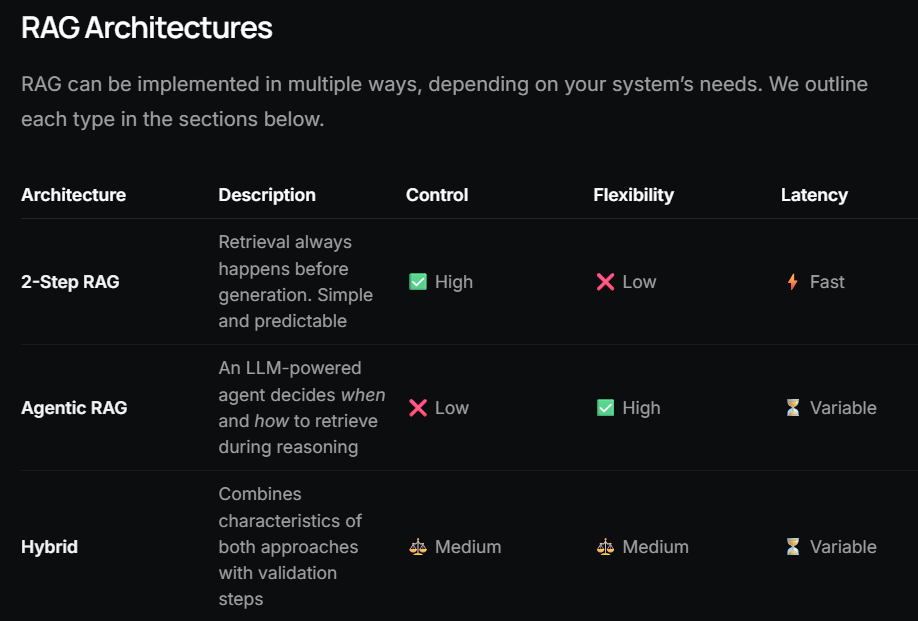

### Agentic RAG
Agentic Retrieval-Augmented Generation (RAG) combines the strengths of Retrieval-Augmented Generation with agent-based reasoning. Instead of retrieving documents before answering, an agent (powered by an LLM) reasons step-by-step and decides when and how to retrieve information during the interaction.
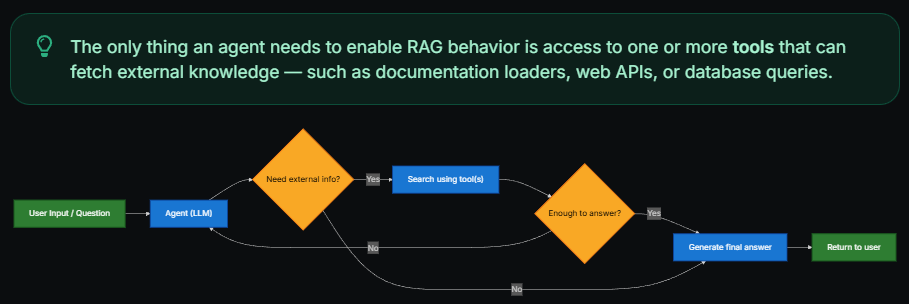

In [ ]:
import requests
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langchain.tools import tool
from markdownify import markdownify


ALLOWED_DOMAINS = ["https://langchain-ai.github.io/"]
LLMS_TXT = 'https://langchain-ai.github.io/langgraph/llms.txt'


@tool
def fetch_documentation(url: str) -> str:  
    """Fetch and convert documentation from a URL"""
    if not any(url.startswith(domain) for domain in ALLOWED_DOMAINS):
        return (
            "Error: URL not allowed. "
            f"Must start with one of: {', '.join(ALLOWED_DOMAINS)}"
        )
    response = requests.get(url, timeout=10.0)
    response.raise_for_status()
    return markdownify(response.text)


# We will fetch the content of llms.txt, so this can
# be done ahead of time without requiring an LLM request.
llms_txt_content = requests.get(LLMS_TXT).text

# System prompt for the agent
system_prompt = f"""
You are an expert Python developer and technical assistant.
Your primary role is to help users with questions about LangGraph and related tools.

Instructions:

1. If a user asks a question you're unsure about — or one that likely involves API usage,
   behavior, or configuration — you MUST use the `fetch_documentation` tool to consult the relevant docs.
2. When citing documentation, summarize clearly and include relevant context from the content.
3. Do not use any URLs outside of the allowed domain.
4. If a documentation fetch fails, tell the user and proceed with your best expert understanding.

You can access official documentation from the following approved sources:

{llms_txt_content}

You MUST consult the documentation to get up to date documentation
before answering a user's question about LangGraph.

Your answers should be clear, concise, and technically accurate.
"""

tools = [fetch_documentation]

model = init_chat_model("claude-sonnet-4-0", max_tokens=32_000)

agent = create_agent(
    model=model,
    tools=tools,  
    system_prompt=system_prompt,  
    name="Agentic RAG",
)

response = agent.invoke({
    'messages': [
        HumanMessage(content=(
            "Write a short example of a langgraph agent using the "
            "prebuilt create react agent. the agent should be able "
            "to look up stock pricing information."
        ))
    ]
})

print(response['messages'][-1].content)

### 2-step RAG
In 2-Step RAG, the retrieval step is always executed before the generation step. This architecture is straightforward and predictable, making it suitable for many applications where the retrieval of relevant documents is a clear prerequisite for generating an answer.
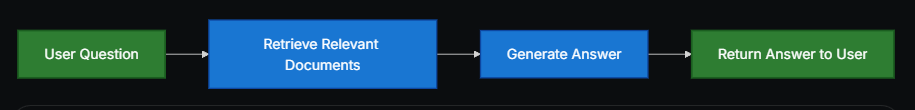

In [ ]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest

@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
    """Inject context into state messages."""
    last_query = request.state["messages"][-1].text
    retrieved_docs = vector_store.similarity_search(last_query)

    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    system_message = (
        "You are a helpful assistant. Use the following context in your response:"
        f"\n\n{docs_content}"
    )

    return system_message


agent = create_agent(model, tools=[], middleware=[prompt_with_context])